In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json
import pandas as pd
import numpy as np
from datasets import load_dataset

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir(os.path.dirname(os.getcwd()))

import debias_vsi as dv

In [3]:
df = dv.get_vsi_with_scores()
df

Evaluating /Users/ebrown/workspace/vsibench_debiased_internal/data/ref_evals/bld_sims_3q_10k_blind.jsonl: 100%|██████████| 5130/5130 [00:00<00:00, 14116.48it/s]
Evaluating /Users/ebrown/workspace/vsibench_debiased_internal/data/ref_evals/blk_sims_3q_10k_blind.jsonl: 100%|██████████| 5130/5130 [00:00<00:00, 15863.21it/s]
Evaluating /Users/ebrown/workspace/vsibench_debiased_internal/data/ref_evals/cambrian-s.jsonl: 100%|██████████| 5130/5130 [00:00<00:00, 15717.39it/s]
Evaluating /Users/ebrown/workspace/vsibench_debiased_internal/data/ref_evals/cambrian-s_blind.jsonl: 100%|██████████| 5130/5130 [00:00<00:00, 16003.75it/s]
Evaluating /Users/ebrown/workspace/vsibench_debiased_internal/data/ref_evals/gemini-1.5_pro.jsonl: 100%|██████████| 5156/5156 [00:00<00:00, 13272.66it/s]
Evaluating /Users/ebrown/workspace/vsibench_debiased_internal/data/ref_evals/llava_vid_7b.jsonl: 100%|██████████| 5156/5156 [00:00<00:00, 14524.64it/s]
Evaluating /Users/ebrown/workspace/vsibench_debiased_internal/data

Loaded 5130 files. Loading VSI-Bench...


,id,dataset,scene_name,question_type,question,ground_truth,options,bld_sims_3q_10k_blind,blk_sims_3q_10k_blind,cambrian-s,...,rgb_sims_3q_25k,rgb_sims_3q_25k_blind,rgb_sims_manV2_5k,rgb_sims_manV2_5k_blind,vsi_train_10k,vsi_train_10k_blind,vsi_train_50k,vsi_train_50k_blind,vsi_train_5k,vsi_train_5k_blind
0,0,arkitscenes,41069025,object_counting,How many table(s) are in this room?,4,None,0.0,0.0,0.1,...,0.1,0.0,0.1,0.0,0.1,0.1,0.1,0.1,0.1,0.1
1,1,arkitscenes,41069025,object_counting,How many chair(s) are in this room?,2,None,0.1,0.1,1.0,...,0.1,0.1,0.1,0.1,1.0,1.0,1.0,1.0,1.0,1.0
2,2,arkitscenes,41069043,object_counting,How many table(s) are in this room?,2,None,0.1,0.1,1.0,...,1.0,0.1,1.0,0.1,1.0,1.0,1.0,1.0,1.0,1.0
3,3,arkitscenes,41125700,object_counting,How many sofa(s) are in this room?,2,None,0.1,0.1,1.0,...,0.1,0.1,0.1,0.1,1.0,1.0,1.0,1.0,1.0,1.0
4,4,arkitscenes,41125700,object_counting,How many table(s) are in this room?,3,None,0.0,0.0,0.4,...,0.4,0.0,0.4,0.0,0.4,0.4,0.4,0.4,0.4,0.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5125,5151,scannet,scene0196_00,route_planning,You are a robot beginning at the trash bin nea...,C,"[A. Turn Right, Turn Left, B. Turn Right, Turn...",0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5126,5152,scannet,scene0378_01,route_planning,You are a robot beginning at the door and faci...,A,"[A. Turn Left, Turn Left, Turn Left, B. Turn L...",0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5127,5153,arkitscenes,47331654,route_planning,You are a robot beginning at the heater and fa...,D,"[A. Turn Left, Turn Right, B. Turn Back, Turn ...",0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5128,5154,arkitscenes,42445026,route_planning,You are a robot beginning at the doorframe and...,C,"[A. Turn Left, B. Turn Back, C. Turn Right]",1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


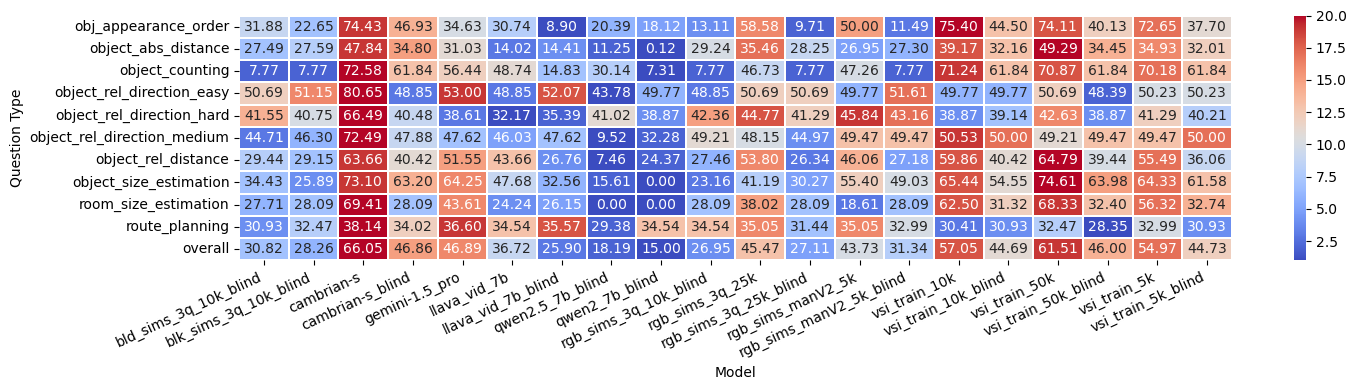

In [4]:
dv.visualize_model_scores(df);

## Relative Distance

In [5]:
qdf = df[df["question_type"] == "object_rel_distance"].copy()

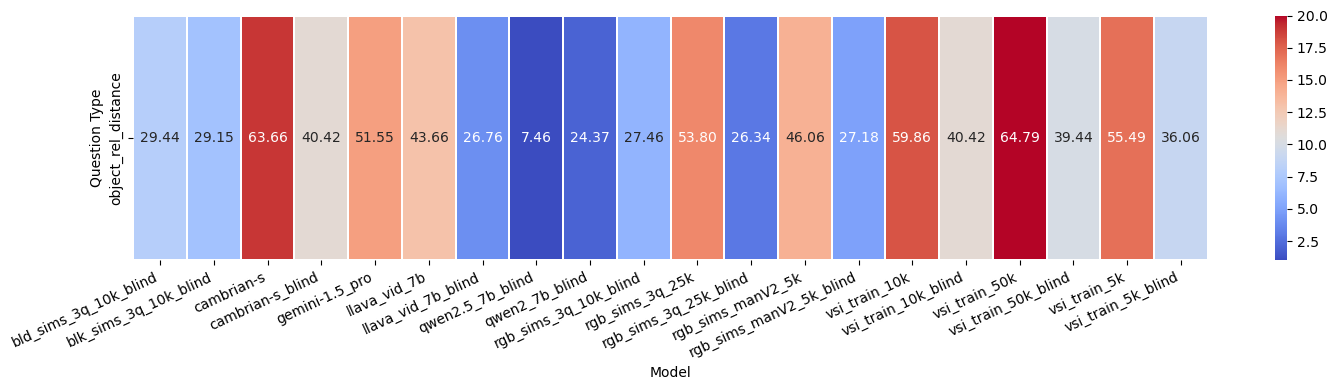

In [6]:
dv.visualize_model_scores(qdf);

In [7]:
i=0
qdf["question"].iloc[i], qdf["options"].iloc[i].tolist(), qdf["ground_truth"].iloc[i],

('Measuring from the closest point of each object, which of these objects (chair, stool, stove, sofa) is the closest to the tv?',
 ['A. chair', 'B. stool', 'C. stove', 'D. sofa'],
 'A')

In [8]:
import re

## question format: "What is the length of the longest dimension (length, width, or height) of the OBJECT, measured in centimeters?'"
## question format: "How many OBJECT(s) are in this room?"
## question format: "Measuring from the closest point of each object, what is the distance between the sofa and the stove (in meters)?"
# question format: "Measuring from the closest point of each object, which of these objects (chair, stool, stove, sofa) is the closest to the tv?"


qdf["gt_idx"] = qdf["ground_truth"].apply(lambda x: "ABCD".index(x))
qdf["gt_option"] = qdf.apply(lambda row: row["options"][row["gt_idx"]], axis=1)
qdf["gt_object"] = qdf.apply(lambda row: row["options"][row["gt_idx"]].split(". ")[-1], axis=1)
qdf[["object_1", "object_2", "object_3", "object_4", "target_object"]] = qdf["question"].str.extract(r'which of these objects \((.*?), (.*?), (.*?), (.*?)\) is the closest to the (.*?)\?$')
qdf["tgt_opt_pair"] = qdf.apply(lambda row: "-".join(sorted([row["target_object"], row["gt_option"]])), axis=1)
qdf["tgt_gt_pair"] = qdf.apply(lambda row: "-".join(sorted([row["target_object"], row["gt_object"]])), axis=1)
qdf["tgt_gt_ord_pair"] = qdf.apply(lambda row: row["target_object"] + "-" + row["gt_object"], axis=1)

for i in range(4):
    assert (qdf["options"].apply(lambda x: x[i].split(". ")[-1]) == qdf[f"object_{i+1}"]).all()
# --> it seems that the objects are always in the same order as the options

qdf.iloc[0]

id                                                                      1334
dataset                                                          arkitscenes
scene_name                                                          42446103
question_type                                            object_rel_distance
question                   Measuring from the closest point of each objec...
ground_truth                                                               A
options                              [A. chair, B. stool, C. stove, D. sofa]
bld_sims_3q_10k_blind                                                    1.0
blk_sims_3q_10k_blind                                                    1.0
cambrian-s                                                               1.0
cambrian-s_blind                                                         1.0
gemini-1.5_pro                                                           0.0
llava_vid_7b                                                             0.0

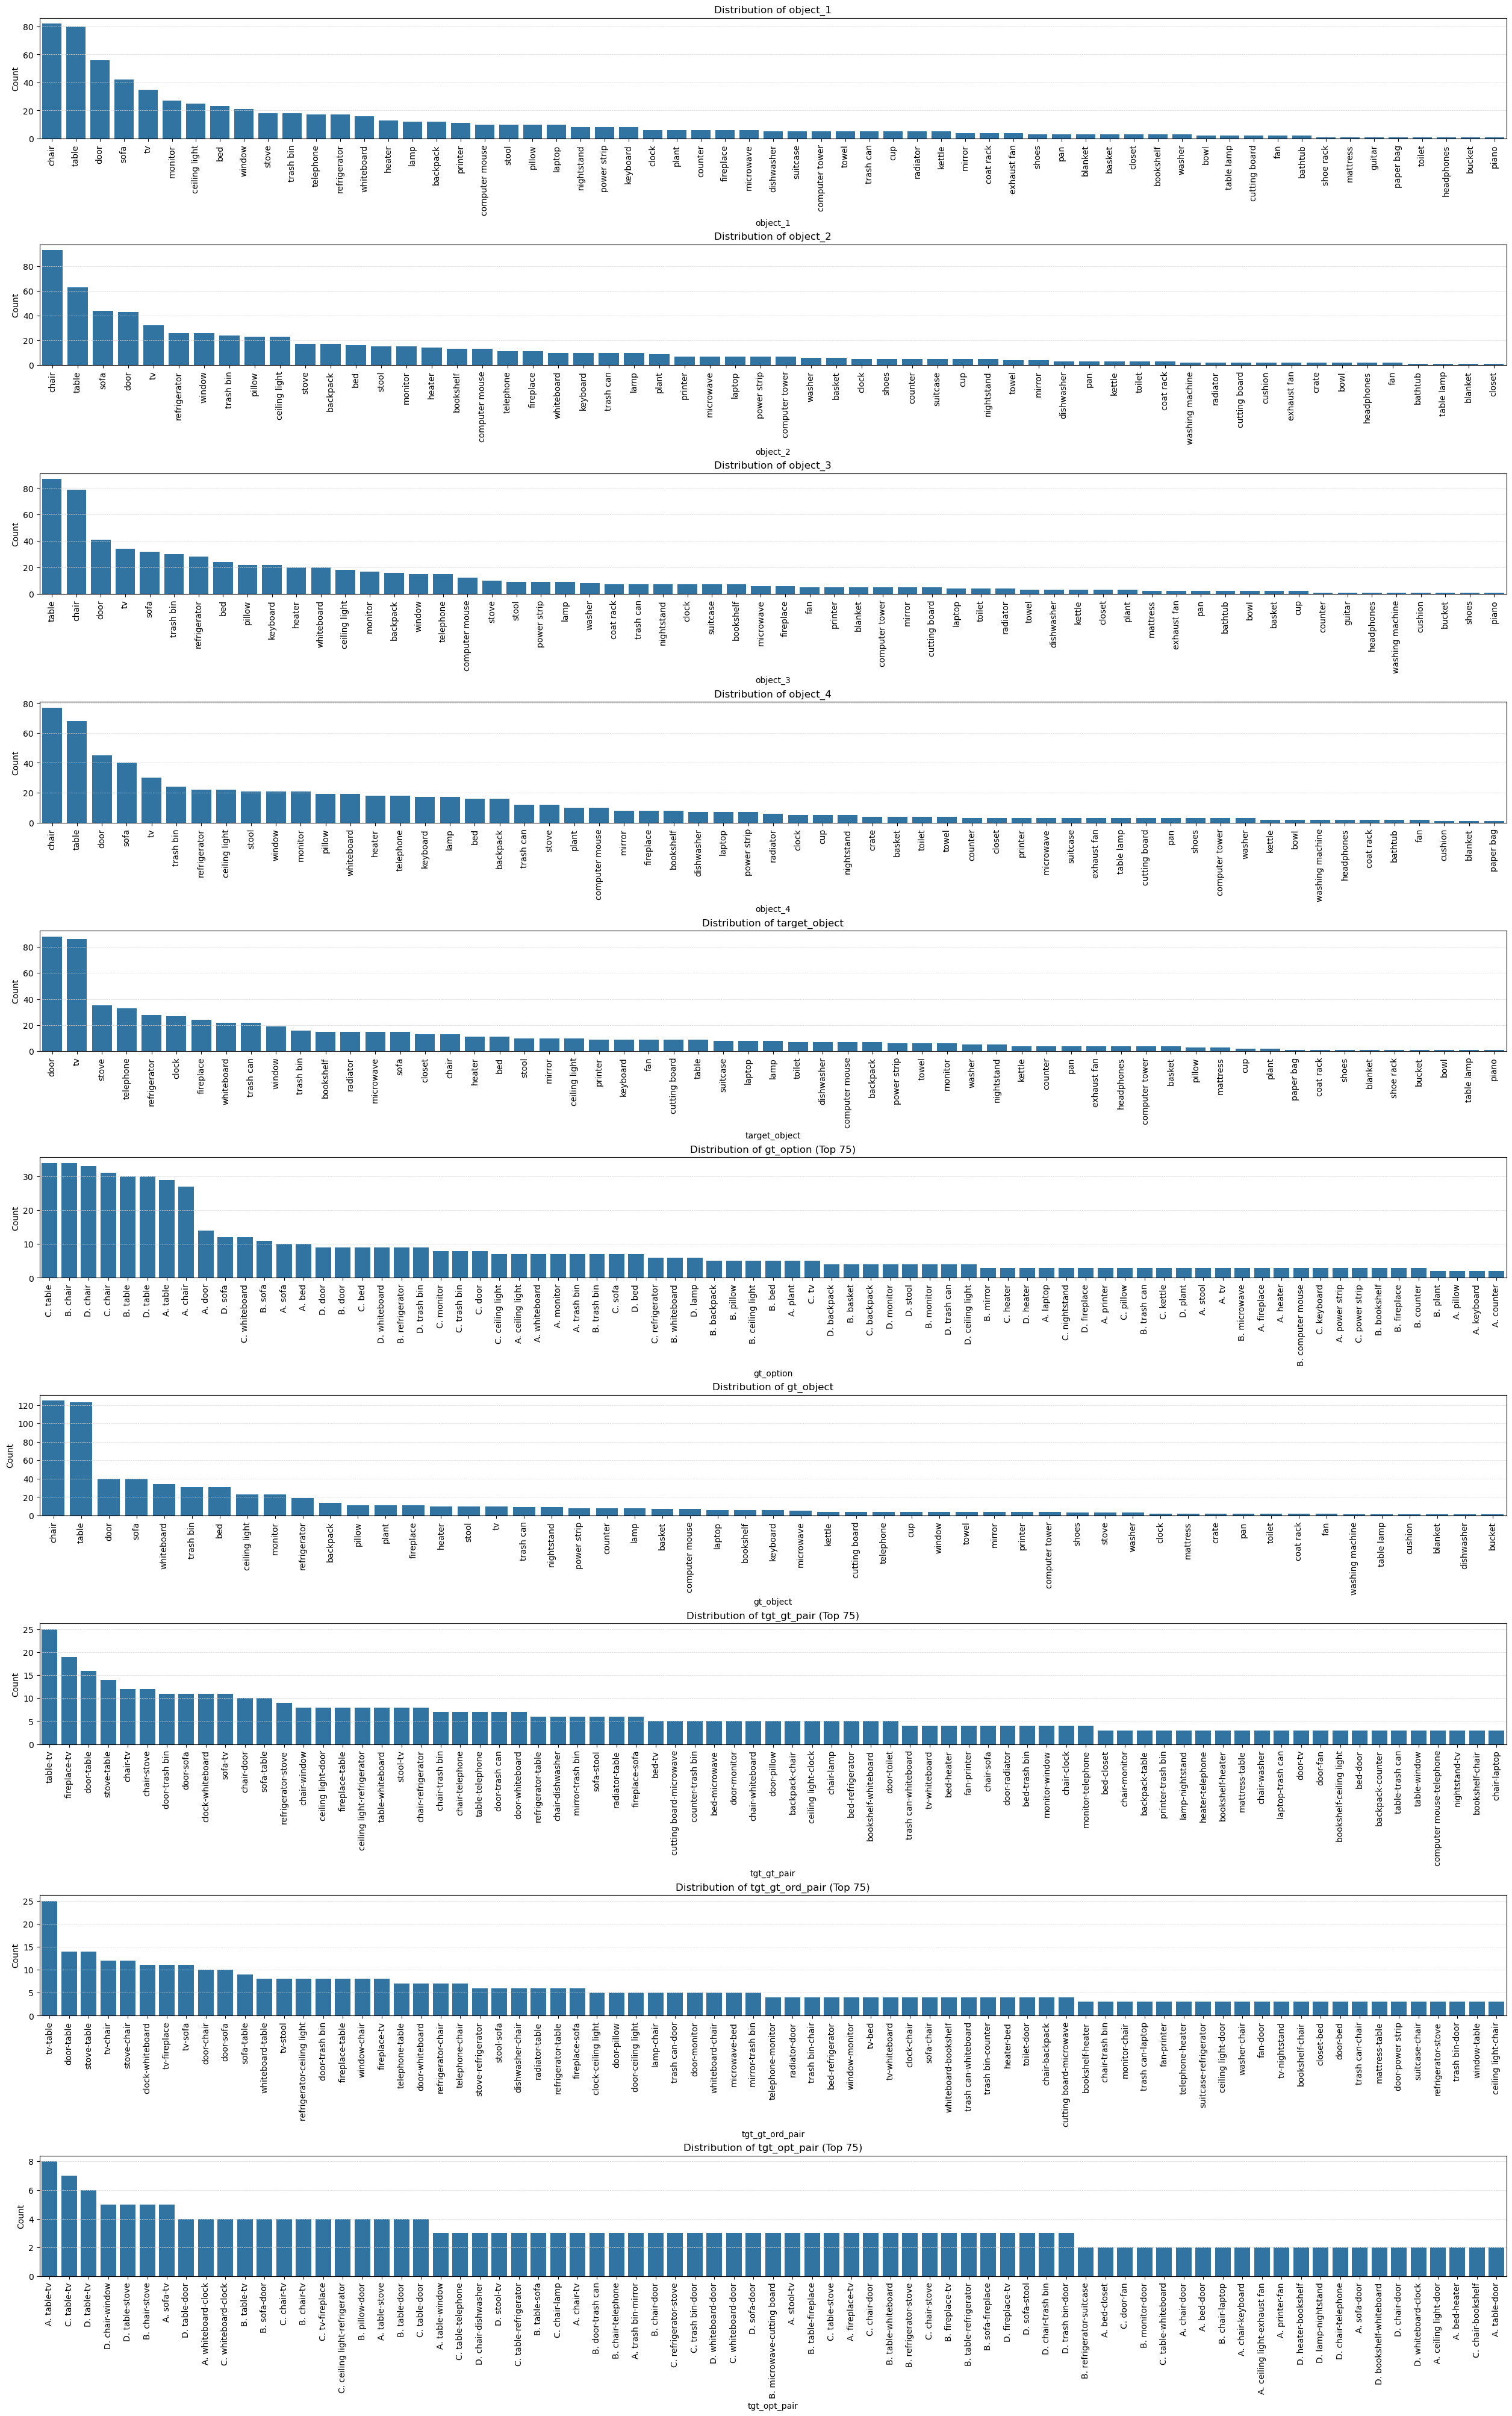

In [9]:
cols = [
    "object_1", "object_2", "object_3", "object_4", "target_object", "gt_option", "gt_object", "tgt_gt_pair", "tgt_gt_ord_pair", "tgt_opt_pair"
]

fig, axes = plt.subplots(len(cols), 1, figsize=(25, 4 * len(cols)), constrained_layout=True)

max_k = 75
for i, col in enumerate(cols):
    top_values = qdf[col].value_counts().head(max_k).index
    sns.countplot(data=qdf[qdf[col].isin(top_values)], x=col, order=top_values, ax=axes[i])
    title = f"Distribution of {col}"
    if len(top_values) == max_k:
        title += f" (Top {max_k})"
    axes[i].grid(visible=True, which='major', axis='y', color='lightgray', linestyle='--', linewidth=0.5)
    axes[i].set_title(title)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")
    axes[i].tick_params(axis='x', rotation=90)

plt.show()

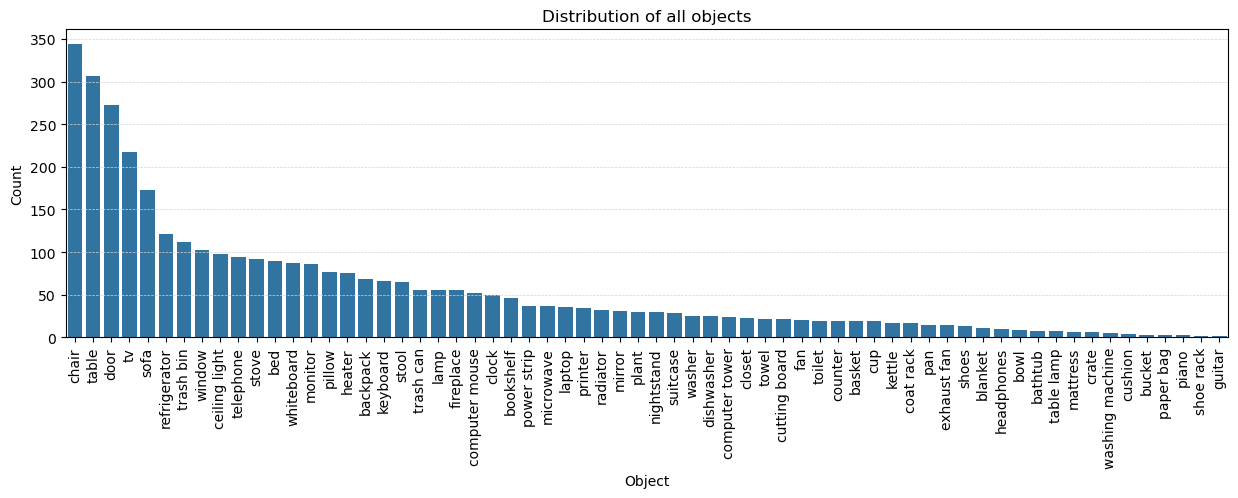

In [10]:
fig, ax = plt.subplots(figsize=(15, 4))
ax.grid(visible=True, which='both', color='lightgray', linestyle='--', linewidth=0.5)
# finally, also plot the distribution of distinct objects in either slot (object_1 or object_2)
all_objects = (
    qdf["object_1"].tolist() +
    qdf["object_2"].tolist() +
    qdf["object_3"].tolist() +
    qdf["object_4"].tolist() +
    qdf["target_object"].tolist()
)
all_objects = pd.Series(all_objects).value_counts().reset_index()
# just plot the object and values normally
sns.barplot(data=all_objects, x="index", y="count", ax=ax)
ax.set_title("Distribution of all objects")
ax.set_xlabel("Object")
ax.set_ylabel("Count")
ax.tick_params(axis='x', rotation=90)
plt.show()

In [11]:
qdf.iloc[0]

id                                                                      1334
dataset                                                          arkitscenes
scene_name                                                          42446103
question_type                                            object_rel_distance
question                   Measuring from the closest point of each objec...
ground_truth                                                               A
options                              [A. chair, B. stool, C. stove, D. sofa]
bld_sims_3q_10k_blind                                                    1.0
blk_sims_3q_10k_blind                                                    1.0
cambrian-s                                                               1.0
cambrian-s_blind                                                         1.0
gemini-1.5_pro                                                           0.0
llava_vid_7b                                                             0.0

In [12]:
qdf["ground_truth"].value_counts()

ground_truth
B    178
D    178
A    177
C    177
Name: count, dtype: int64

In [13]:
len(qdf)

710

In [14]:
pd.set_option('display.max_rows', 100)
budget = 400

Global pair counts: Counter({('A. table', 'tv'): 8, ('C. table', 'tv'): 7, ('D. table', 'tv'): 6, ('D. table', 'stove'): 5, ('B. chair', 'stove'): 5, ('A. sofa', 'tv'): 5, ('D. chair', 'window'): 5, ('B. table', 'tv'): 4, ('A. table', 'stove'): 4, ('C. tv', 'fireplace'): 4, ('C. chair', 'tv'): 4, ('B. chair', 'tv'): 4, ('C. whiteboard', 'clock'): 4, ('A. whiteboard', 'clock'): 4, ('D. table', 'door'): 4, ('C. ceiling light', 'refrigerator'): 4, ('B. sofa', 'door'): 4, ('B. pillow', 'door'): 4, ('C. table', 'door'): 4, ('B. table', 'door'): 4, ('A. chair', 'tv'): 3, ('D. sofa', 'stool'): 3, ('B. table', 'refrigerator'): 3, ('C. chair', 'stove'): 3, ('B. refrigerator', 'stove'): 3, ('D. fireplace', 'tv'): 3, ('A. fireplace', 'tv'): 3, ('B. fireplace', 'tv'): 3, ('B. sofa', 'fireplace'): 3, ('C. table', 'stove'): 3, ('B. table', 'fireplace'): 3, ('D. chair', 'dishwasher'): 3, ('B. table', 'sofa'): 3, ('A. stool', 'tv'): 3, ('C. table', 'refrigerator'): 3, ('D. stool', 'tv'): 3, ('C. refri

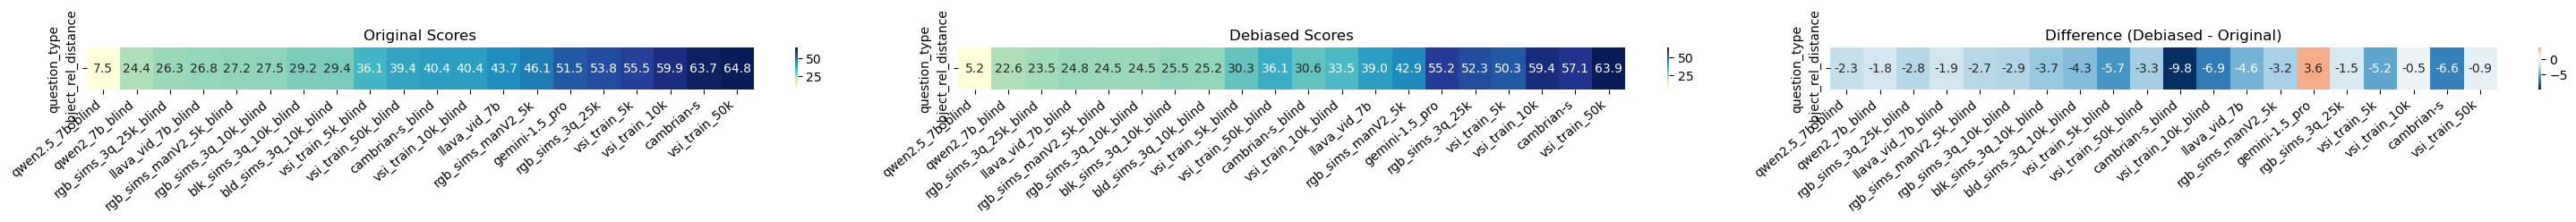

In [15]:
ids = dv.filter_object_rel_distance_score(qdf, budget=budget)
deb_qdf = qdf.loc[~qdf["id"].isin(ids)]
removed_qdf = qdf.loc[qdf["id"].isin(ids)]
print(f"Removed {len(removed_qdf)} samples from the dataset. Now {len(deb_qdf)} samples remain.")
dv.visualize_debiasing_impact(qdf, deb_qdf);

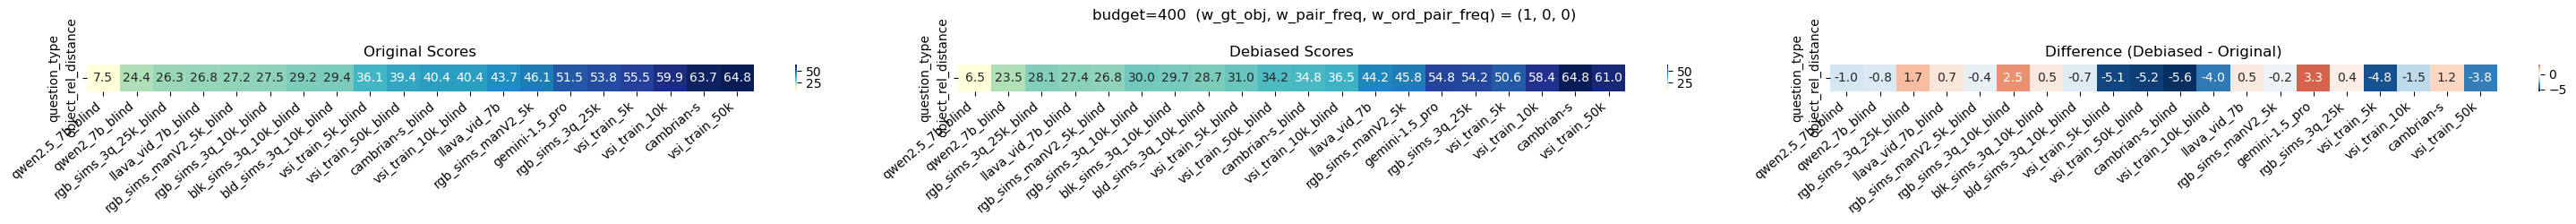

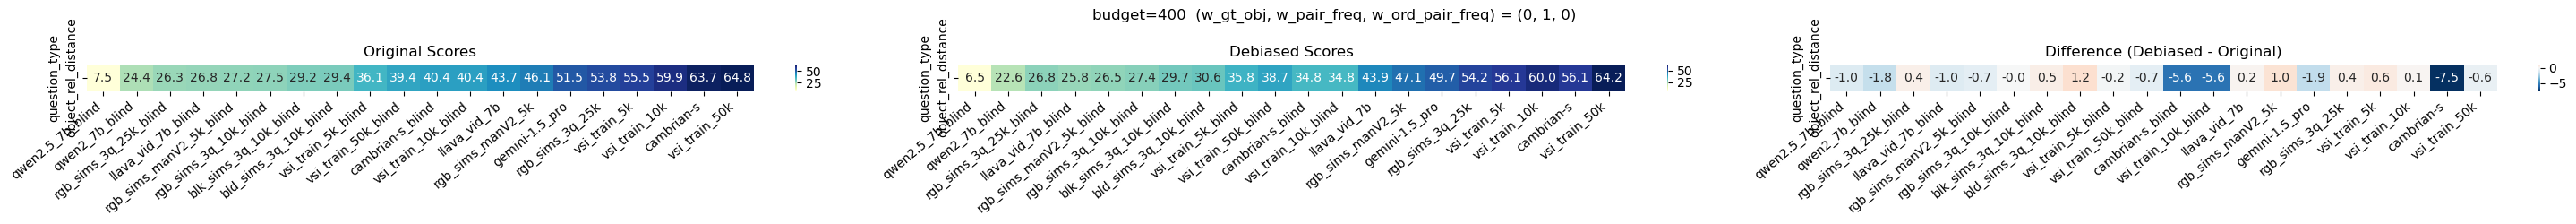

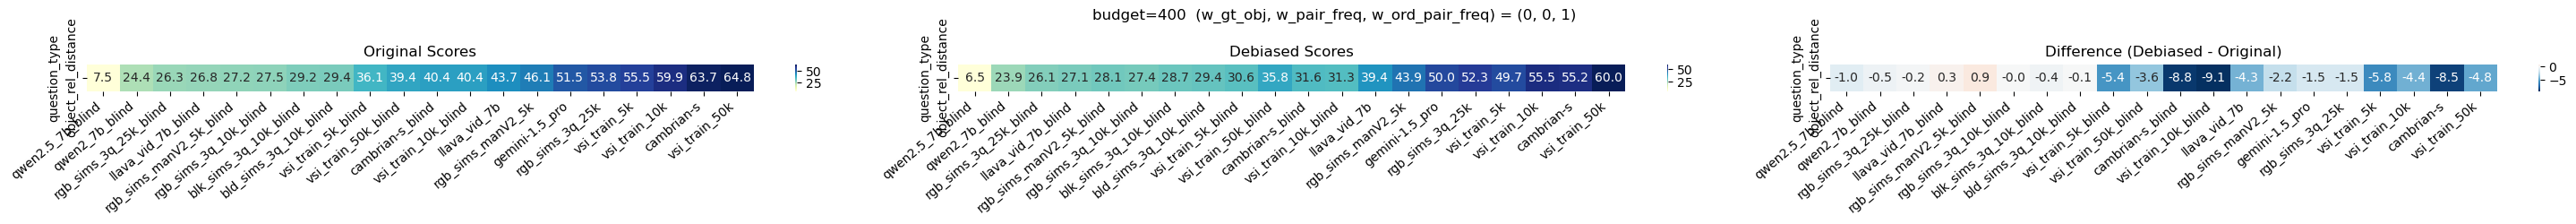

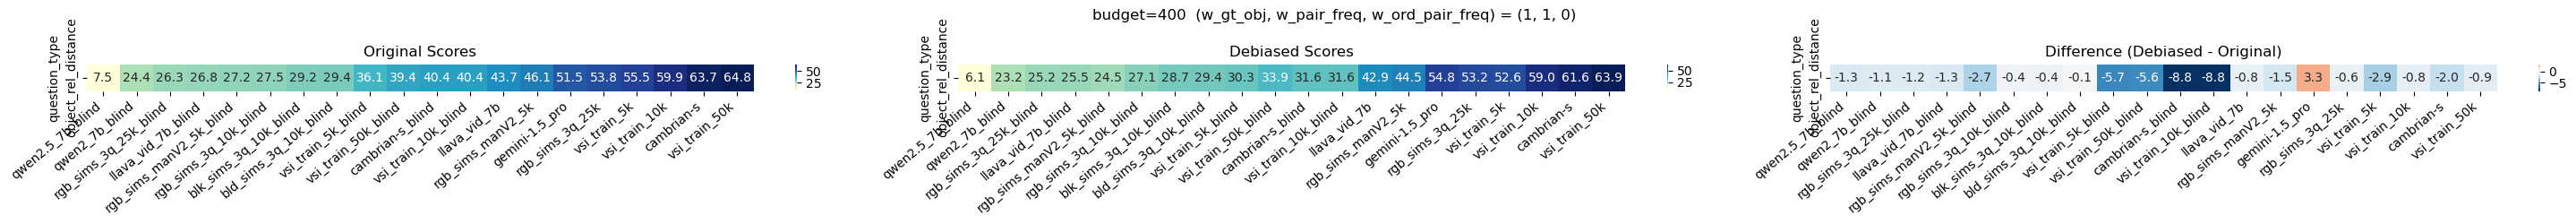

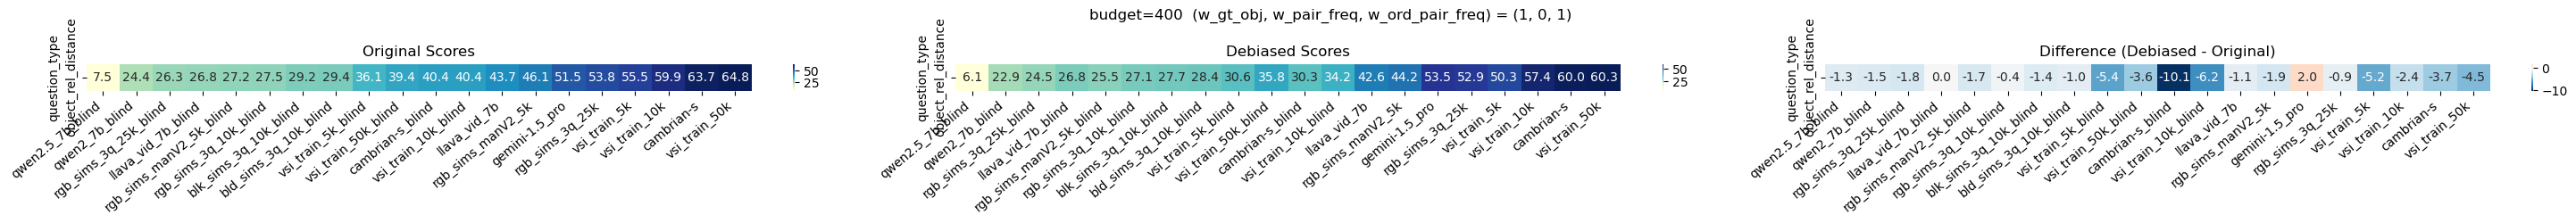

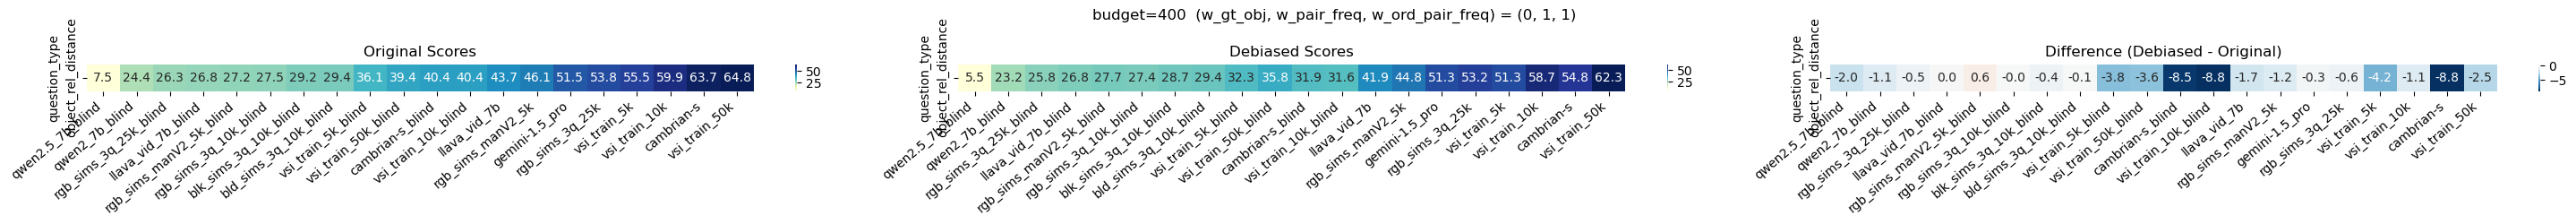

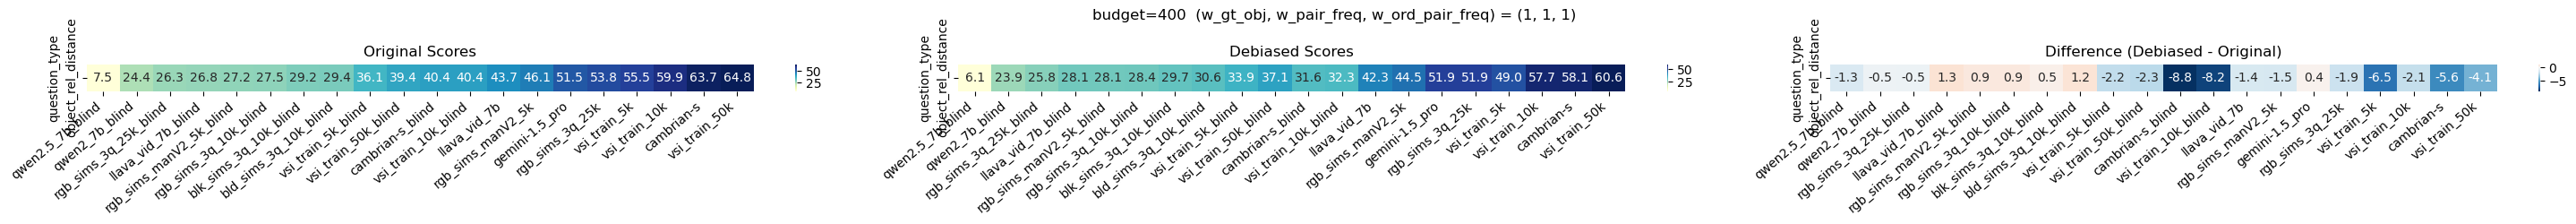

In [16]:
for w_gt_obj, w_pair_freq, w_ord_pair_freq in (
    (1, 0, 0),
    (0, 1, 0),
    (0, 0, 1),
    (1, 1, 0),
    (1, 0, 1),
    (0, 1, 1),
    (1, 1, 1),
    # (1, 2, 2),
):
    ids = dv.filter_object_rel_distance_score_v2(qdf, budget=budget, w_gt_obj=w_gt_obj, w_pair_freq=w_pair_freq, w_ord_pair_freq=w_ord_pair_freq)
    deb_qdf = qdf.loc[~qdf["id"].isin(ids)]
    removed_qdf = qdf.loc[qdf["id"].isin(ids)]
    dv.visualize_debiasing_impact(qdf, deb_qdf, title=f"budget={budget}  (w_gt_obj, w_pair_freq, w_ord_pair_freq) = ({w_gt_obj}, {w_pair_freq}, {w_ord_pair_freq})");

In [17]:
removed_qdf.head()

,id,dataset,scene_name,question_type,question,ground_truth,options,bld_sims_3q_10k_blind,blk_sims_3q_10k_blind,cambrian-s,...,gt_option,gt_object,object_1,object_2,object_3,object_4,target_object,tgt_opt_pair,tgt_gt_pair,tgt_gt_ord_pair
1332,1336,arkitscenes,42446103,object_rel_distance,Measuring from the closest point of each objec...,C,"[A. chair, B. tv, C. sofa, D. stove]",0.0,0.0,1.0,...,C. sofa,sofa,chair,tv,sofa,stove,stool,C. sofa-stool,sofa-stool,stool-sofa
1335,1339,arkitscenes,42446103,object_rel_distance,Measuring from the closest point of each objec...,D,"[A. stove, B. tv, C. table, D. sofa]",0.0,0.0,1.0,...,D. sofa,sofa,stove,tv,table,sofa,stool,D. sofa-stool,sofa-stool,stool-sofa
1337,1341,arkitscenes,42446541,object_rel_distance,Measuring from the closest point of each objec...,C,"[A. tv, B. table, C. chair, D. sofa]",0.0,0.0,1.0,...,C. chair,chair,tv,table,chair,sofa,washer,C. chair-washer,chair-washer,washer-chair
1338,1342,arkitscenes,42897538,object_rel_distance,Measuring from the closest point of each objec...,A,"[A. sofa, B. stool, C. table, D. tv]",1.0,1.0,1.0,...,A. sofa,sofa,sofa,stool,table,tv,refrigerator,A. sofa-refrigerator,refrigerator-sofa,refrigerator-sofa
1342,1346,arkitscenes,42897629,object_rel_distance,Measuring from the closest point of each objec...,A,"[A. table, B. washer, C. refrigerator, D. sofa]",1.0,1.0,0.0,...,A. table,table,table,washer,refrigerator,sofa,stove,A. table-stove,stove-table,stove-table


In [18]:
a = dv.evaluate_models(qdf.loc[qdf["id"].isin(ids)])
b = dv.evaluate_models(qdf.loc[~qdf["id"].isin(ids)])
c = dv.evaluate_models(qdf)
d = b - c
# concat the dfs
# pd.concat([a, b], axis=0, ignore_index=True).rename(index={0: "Removed", 1: "Debiased"})
# pd.concat([a, b, c], axis=0, ignore_index=True).rename(index={0: "Removed", 1: "Debiased", 2: "Original"})
pd.concat([a, b, c, d], axis=0, ignore_index=True).rename(index={0: "Removed", 1: "Debiased", 2: "Original", 3: "Difference"}).T.sort_values("Difference")

,Removed,Debiased,Original,Difference
cambrian-s_blind,47.25,31.612903,40.422535,-8.809632
vsi_train_10k_blind,46.75,32.258065,40.422535,-8.164471
vsi_train_5k,60.50,49.032258,55.492958,-6.460700
cambrian-s,68.00,58.064516,63.661972,-5.597456
vsi_train_50k,68.00,60.645161,64.788732,-4.143571
vsi_train_50k_blind,41.25,37.096774,39.436620,-2.339846
vsi_train_5k_blind,37.75,33.870968,36.056338,-2.185370
vsi_train_10k,61.50,57.741935,59.859155,-2.117219
rgb_sims_3q_25k,55.25,51.935484,53.802817,-1.867333
rgb_sims_manV2_5k,47.25,44.516129,46.056338,-1.540209


Global pair counts: Counter({('A. table', 'tv'): 8, ('C. table', 'tv'): 7, ('D. table', 'tv'): 6, ('D. table', 'stove'): 5, ('B. chair', 'stove'): 5, ('A. sofa', 'tv'): 5, ('D. chair', 'window'): 5, ('B. table', 'tv'): 4, ('A. table', 'stove'): 4, ('C. tv', 'fireplace'): 4, ('C. chair', 'tv'): 4, ('B. chair', 'tv'): 4, ('C. whiteboard', 'clock'): 4, ('A. whiteboard', 'clock'): 4, ('D. table', 'door'): 4, ('C. ceiling light', 'refrigerator'): 4, ('B. sofa', 'door'): 4, ('B. pillow', 'door'): 4, ('C. table', 'door'): 4, ('B. table', 'door'): 4, ('A. chair', 'tv'): 3, ('D. sofa', 'stool'): 3, ('B. table', 'refrigerator'): 3, ('C. chair', 'stove'): 3, ('B. refrigerator', 'stove'): 3, ('D. fireplace', 'tv'): 3, ('A. fireplace', 'tv'): 3, ('B. fireplace', 'tv'): 3, ('B. sofa', 'fireplace'): 3, ('C. table', 'stove'): 3, ('B. table', 'fireplace'): 3, ('D. chair', 'dishwasher'): 3, ('B. table', 'sofa'): 3, ('A. stool', 'tv'): 3, ('C. table', 'refrigerator'): 3, ('D. stool', 'tv'): 3, ('C. refri

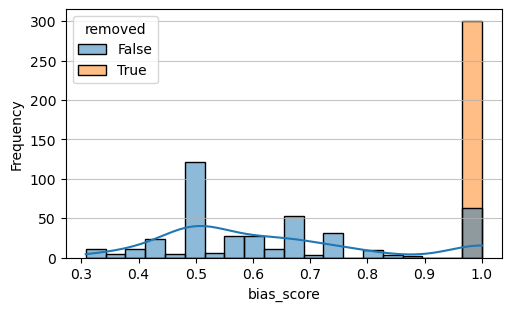

In [19]:
budget = 300

remove_ids = dv.filter_object_rel_distance_score(qdf, budget)
df_filtered = dv.get_object_rel_distance_score(qdf)
df_sorted = df_filtered.sort_values("bias_score", ascending=False)
df_sorted["removed"] = df_sorted["id"].isin(remove_ids)


# scores = ["obj_freq_score", "val_freq_score", "combo_freq_score", "bias_score"]
# scores = ["pair_freq_score", "inv_var_score", "close_score", "bias_score"]
scores = ["bias_score"]

# Visualize the distribution of scores in subplots
fig, axes = plt.subplots(1, len(scores), figsize=(5*len(scores), 3), constrained_layout=True)
if len(scores) == 1:
    axes = [axes]  # Ensure axes is iterable even if there's only one score

for i, score in enumerate(scores):
    sns.histplot(data=df_sorted, x=score, bins=20, kde=True, hue="removed", ax=axes[i])
    axes[i].set_ylabel("Frequency")
    axes[i].grid(axis='y', alpha=0.75)
plt.show()

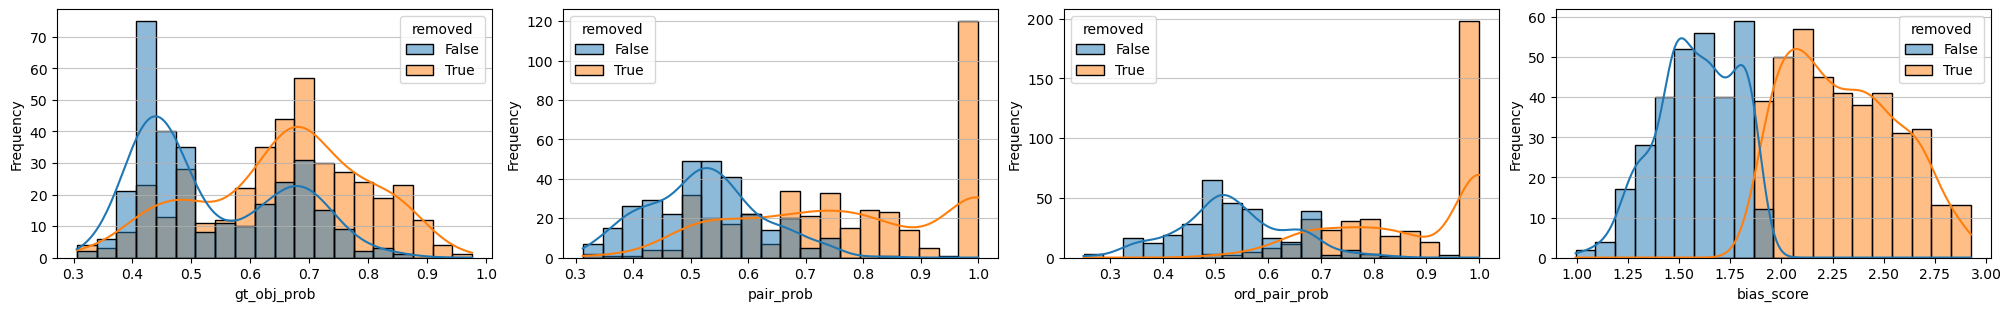

In [20]:
budget = 400

w_gt_obj: float = 1.0
w_pair_freq: float = 1.0
w_ord_pair_freq: float = 1.0

remove_ids = dv.filter_object_rel_distance_score_v2(qdf, budget, w_gt_obj=w_gt_obj, w_pair_freq=w_pair_freq, w_ord_pair_freq=w_ord_pair_freq)
df_filtered = dv.get_object_rel_distance_score_v2(qdf, w_gt_obj=w_gt_obj, w_pair_freq=w_pair_freq, w_ord_pair_freq=w_ord_pair_freq)
df_sorted = df_filtered.sort_values("bias_score", ascending=False)
df_sorted["removed"] = df_sorted["id"].isin(remove_ids)


# scores = ["obj_freq_score", "val_freq_score", "combo_freq_score", "bias_score"]
# scores = ["pair_freq_score", "inv_var_score", "close_score", "bias_score"]
scores = ["gt_obj_prob", "pair_prob", "ord_pair_prob", "bias_score"]

# Visualize the distribution of scores in subplots
fig, axes = plt.subplots(1, len(scores), figsize=(5*len(scores), 3), constrained_layout=True)
if len(scores) == 1:
    axes = [axes]  # Ensure axes is iterable even if there's only one score

for i, score in enumerate(scores):
    sns.histplot(data=df_sorted, x=score, bins=20, kde=True, hue="removed", ax=axes[i])
    axes[i].set_ylabel("Frequency")
    axes[i].grid(axis='y', alpha=0.75)
plt.show()

In [21]:
import numpy as np # Added for mean/std calculation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, make_scorer # Added make_scorer for cross_val_score
from sklearn.model_selection import StratifiedKFold, cross_val_score # Added KFold and cross_val_score
from sklearn.preprocessing import LabelEncoder

def evaluate_rf_bias_cv(scored_df: pd.DataFrame, n_splits: int = 5) -> tuple[float, float, pd.DataFrame]:
    """
    Trains and evaluates a RandomForestClassifier using k-fold cross-validation
    on non-visual features of object_rel_distance questions to predict the
    ground truth answer ('A'/'B'/'C'/'D').

    Args:
        scored_df: DataFrame containing features and the 'ground_truth' target column.
                   Expected features: 'object_1', 'object_2', 'object_3', 'object_4',
                                      'target_object', 'gt_obj_prob', 'pair_prob',
                                      'ord_pair_prob'.
        n_splits: Number of folds for StratifiedKFold cross-validation.

    Returns:
        A tuple containing:
        - mean_accuracy (float): Mean accuracy across the cross-validation folds.
        - std_accuracy (float): Standard deviation of accuracy across the folds.
        - feature_importance_df (pd.DataFrame | None): DataFrame with feature importances
          from a model trained on the full dataset, or None if calculation fails.
    """
    print(f"--- Starting RF Bias Evaluation (CV with {n_splits} splits) ---")

    # --- 1. Select Features and Target ---
    feature_cols = [
        'object_1', 'object_2', 'object_3', 'object_4', 'target_object',
        'gt_obj_prob', 'pair_prob', 'ord_pair_prob'
    ]
    target_col = 'ground_truth'

    # Check for essential columns
    required_cols = feature_cols + [target_col]
    missing_cols = [col for col in required_cols if col not in scored_df.columns]
    if missing_cols:
        print(f"Error: Input DataFrame is missing required columns: {missing_cols}")
        raise ValueError(f"Missing required columns: {missing_cols}")

    # Create a working copy and drop rows with missing values in relevant columns
    data = scored_df[required_cols].copy()
    initial_rows = len(data)
    data.dropna(inplace=True)
    final_rows = len(data)
    if final_rows < initial_rows:
        print(f"Warning: Dropped {initial_rows - final_rows} rows due to missing values in features or target.")

    if data.empty:
        print("Error: DataFrame is empty after dropping NA. Cannot proceed.")
        raise ValueError("DataFrame is empty after dropping NA.")

    X = data[feature_cols]
    y = data[target_col]

    print(f"Using {len(X)} samples for evaluation.")

    # --- 2. Preprocess Features ---
    encoders = {}
    X_encoded = X.copy()
    categorical_cols = X.select_dtypes(include='object').columns

    if not categorical_cols.empty:
        print(f"Encoding categorical features: {list(categorical_cols)}")
        for col in categorical_cols:
            encoders[col] = LabelEncoder()
            # Fit on the entire column before cross-validation
            X_encoded[col] = encoders[col].fit_transform(X_encoded[col].astype(str))
    else:
        print("No categorical features found to encode.")

    # --- 3. Define Model and Cross-Validation Strategy ---
    model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

    # Adjust n_splits if necessary based on class distribution
    min_samples_per_class = y.value_counts().min()
    if min_samples_per_class < n_splits:
        print(f"Warning: The least populated class has only {min_samples_per_class} samples.")
        if min_samples_per_class < 2:
            print("Error: The least populated class has less than 2 samples. Cannot perform stratified CV.")
            raise ValueError("Insufficient samples in the smallest class for stratified CV.")
        print(f"Reducing n_splits from {n_splits} to {min_samples_per_class} to match the smallest class size.")
        n_splits = min_samples_per_class

    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # --- 4. Perform Cross-Validation ---
    print(f"Performing {n_splits}-Fold Cross-Validation...")
    try:
        # Use cross_val_score to get accuracy for each fold
        scores = cross_val_score(model, X_encoded, y, cv=cv, scoring='accuracy', n_jobs=-1)
        mean_accuracy = np.mean(scores)
        std_accuracy = np.std(scores)
        print(f"Scores for each fold: {scores}")
        print(f"Mean Accuracy: {mean_accuracy:.4f}")
        print(f"Standard Deviation of Accuracy: {std_accuracy:.4f}")
    except ValueError as e:
        print(f"Error during cross-validation: {e}")
        print("This might happen if a fold doesn't contain samples from all classes, especially with small datasets.")
        return np.nan, np.nan, None # Return NaN if CV fails

    # --- 5. Train Final Model and Get Feature Importances ---
    feature_importance_df = None # Initialize as None
    print("\nTraining final model on all data to get feature importances...")
    try:
        final_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
        final_model.fit(X_encoded, y)
        importances = final_model.feature_importances_
        feature_importance_df = pd.DataFrame({'feature': X_encoded.columns, 'importance': importances})
        feature_importance_df = feature_importance_df.sort_values('importance', ascending=False).reset_index(drop=True)
        print("\nFeature Importances (from final model trained on all data):")
        print(feature_importance_df)
    except Exception as e:
        print(f"Could not calculate feature importances: {e}")

    print("--- Evaluation Complete ---")
    return mean_accuracy, std_accuracy, feature_importance_df

In [22]:
evaluate_rf_bias_cv(df_sorted, n_splits=5);

--- Starting RF Bias Evaluation (CV with 5 splits) ---
Using 710 samples for evaluation.
Encoding categorical features: ['object_1', 'object_2', 'object_3', 'object_4', 'target_object']
Performing 5-Fold Cross-Validation...
Scores for each fold: [0.35211268 0.33802817 0.33098592 0.30985915 0.3028169 ]
Mean Accuracy: 0.3268
Standard Deviation of Accuracy: 0.0181

Training final model on all data to get feature importances...

Feature Importances (from final model trained on all data):
         feature  importance
0    gt_obj_prob    0.151614
1       object_2    0.130650
2       object_4    0.129096
3       object_3    0.126479
4       object_1    0.123533
5  target_object    0.117975
6      pair_prob    0.116833
7  ord_pair_prob    0.103820
--- Evaluation Complete ---


In [23]:
evaluate_rf_bias_cv(df_sorted[~df_sorted["removed"]], n_splits=5);

--- Starting RF Bias Evaluation (CV with 5 splits) ---
Using 310 samples for evaluation.
Encoding categorical features: ['object_1', 'object_2', 'object_3', 'object_4', 'target_object']
Performing 5-Fold Cross-Validation...
Scores for each fold: [0.24193548 0.22580645 0.33870968 0.24193548 0.17741935]
Mean Accuracy: 0.2452
Standard Deviation of Accuracy: 0.0524

Training final model on all data to get feature importances...

Feature Importances (from final model trained on all data):
         feature  importance
0    gt_obj_prob    0.145838
1       object_4    0.136006
2       object_2    0.132684
3      pair_prob    0.124422
4       object_3    0.124278
5  ord_pair_prob    0.121545
6       object_1    0.116693
7  target_object    0.098534
--- Evaluation Complete ---


In [24]:
evaluate_rf_bias_cv(df_sorted[df_sorted["removed"]], n_splits=5);

--- Starting RF Bias Evaluation (CV with 5 splits) ---
Using 400 samples for evaluation.
Encoding categorical features: ['object_1', 'object_2', 'object_3', 'object_4', 'target_object']
Performing 5-Fold Cross-Validation...
Scores for each fold: [0.2875 0.275  0.2375 0.3125 0.4   ]
Mean Accuracy: 0.3025
Standard Deviation of Accuracy: 0.0544

Training final model on all data to get feature importances...

Feature Importances (from final model trained on all data):
         feature  importance
0    gt_obj_prob    0.147782
1       object_4    0.143725
2       object_2    0.138587
3       object_3    0.134342
4       object_1    0.131923
5  target_object    0.128503
6      pair_prob    0.095031
7  ord_pair_prob    0.080107
--- Evaluation Complete ---
